# Estimation of reduction factors from Plaxis simulations
In the following script we are going to compare the deformation of the sheet pile wall in Alpnachstad and the results obtained with the finite element software Plaxis 2D. The deformations on site were measured regularly with an inclinometer. 
This comparison aims at a back calculation of the reduction factors $\beta_D$, whereas the moment distribution was interpolated linearly. Both sections of the instrumented sheet pile wall, pre-grouted and single piles, are investigated.

**Input:**

*   our 'inclinometers' library
*   `'Plaxis_EB_Verformung.csv'`: the deformed sheet pile wall (single piles), computed with Plaxis and varying values of $\beta_D$
*   `'Plaxis_EB_Moment.csv'`: the sheet pile wall moment (single piles), computed with Plaxis and varying values of $\beta_D$


**Output:**

*   an estimation of the reductions factors $\beta_D$.

In [ ]:
#hide
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

# install dependency (nbdev version 1 and patch tornado problem)
!pip3 install --upgrade notebook
!pip3 install -e . -q
!pip3 install nbdev==1.2.11 -q

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done


In [ ]:
# default_exp plaxis_linear

# Import the libraries

In [ ]:
#export
import pandas as pd
import numpy as np
import io
import os
import csv
from datetime import datetime, date, timedelta

from google.colab import files

from copy import copy

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn import linear_model

import re

from spundsteif import inclinometers # we need also our own libraries

# 1.0. Import the data

# 1.1. Read the inclinometers data

In [ ]:
#example
INKLINO_FILE_NAME = './data/df_rawdata_inklino.csv'
df_inklino = inclinometers.run_computation_inklino(INKLINO_FILE_NAME, date(2021,7,7))
# df_inklino

/content/drive/MyDrive/spundsteif/spundsteif/inclinometers.py:53: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(to_drop, 1)
/content/drive/MyDrive/spundsteif/spundsteif/inclinometers.py:79: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['type7','runs'], 1)


# 1.2. Read the Plaxis data

For the time being, the soil model we have used in Plaxis is HS small. Since we are missing a few data from the oedometer test, we cannot use Soft Soil to model the peat. The construction phases are defined as follows: 

*   Initial phase: default phase, gravity is "switched on"
*   Phase 1: the sheet piles are installed into the gorund
*   Phase 2: Baupiste is realised
*   Phase 3: excavation up to 2.0 m depth
*   Phase 4: excavation up to 3.5 m depth, and lowering of groundwater table

The single piles differ from the grouted piles only in terms of length (15 m vs. 13 m). Both scenarios were modelled in Plaxis. However, in the estimation of the reduction factors, we use the Plaxis model with 15 m long PU22-profiles, since the difference between the two scenarios was observed to be insignificant.

In [ ]:
# Plaxis displacement data
df_plaxis = pd.read_csv('./data/Plaxis_EB_Verformung.csv', delimiter=';')
df_plaxis

,Point_01,Length_[m]_01,Angle_[°]_01,Y_coordinate_[m]_01,Phase_4_[m]_01,Point_02,Length_[m]_02,Angle_[°]_02,Y_coordinate_[m]_02,Phase_4_[m]_02,...,Point_08,Length_[m]_08,Angle_[°]_08,Y_coordinate_[m]_08,Phase_4_[m]_08,Point_10,Length_[m]_10,Angle_[°]_10,Y_coordinate_[m]_10,Phase_4_[m]_10
0,0,0.000,0.0,1.000,0.043900,0,0.000,0.0,1.000,0.033800,...,0,0.00,0.0,1.00,0.0183,0,0.00,0.0,1.00,0.0165
1,1,0.125,0.0,0.875,0.043000,1,0.125,0.0,0.875,0.033100,...,1,0.13,0.0,0.88,0.0179,1,0.13,0.0,0.88,0.0162
2,2,0.250,0.0,0.750,0.042000,2,0.250,0.0,0.750,0.032300,...,2,0.25,0.0,0.75,0.0176,2,0.25,0.0,0.75,0.0159
3,3,0.375,0.0,0.625,0.041000,3,0.375,0.0,0.625,0.031600,...,3,0.38,0.0,0.63,0.0172,3,0.38,0.0,0.63,0.0156
4,4,0.500,0.0,0.500,0.040000,4,0.500,0.0,0.500,0.030900,...,4,0.50,0.0,0.50,0.0169,4,0.50,0.0,0.50,0.0153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,124,14.600,180.0,-13.600,0.000441,124,14.600,180.0,-13.600,0.000475,...,124,14.55,180.0,-13.55,0.0005,124,14.55,180.0,-13.55,0.0005
125,125,14.700,180.0,-13.700,0.000433,125,14.700,180.0,-13.700,0.000466,...,125,14.66,180.0,-13.66,0.0005,125,14.66,180.0,-13.66,0.0005
126,126,14.800,180.0,-13.800,0.000426,126,14.800,180.0,-13.800,0.000458,...,126,14.78,180.0,-13.78,0.0005,126,14.78,180.0,-13.78,0.0005
127,127,14.900,180.0,-13.900,0.000418,127,14.900,180.0,-13.900,0.000449,...,127,14.89,180.0,-13.89,0.0005,127,14.89,180.0,-13.89,0.0005


In [ ]:
# Plaxis moment data
df_plaxis_M = pd.read_csv('./data/Plaxis_EB_Moment.csv', delimiter=';')
useless_cols = ['Point_01', 'Point_02', 'Point_04', 'Point_06', 'Point_08', 'Point_10', 'Length_[m]_01', 'Length_[m]_02', 'Length_[m]_04', 'Length_[m]_06', 'Length_[m]_08', 'Length_[m]_10']
df_plaxis_M = df_plaxis_M.drop(columns=useless_cols, axis=1)
df_plaxis_M

,Y_coordinate_[m]_01,Phase_4_[kNm/m]_01,Y_coordinate_[m]_02,Phase_4_[kNm/m]_02,Y_coordinate_[m]_04,Phase_4_[kNm/m]_04,Y_coordinate_[m]_06,Phase_4_[kNm/m]_06,Y_coordinate_[m]_08,Phase_4_[kNm/m]_08,Y_coordinate_[m]_10,Phase_4_[kNm/m]_10
0,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
1,0.88,0.00,0.88,0.00,0.88,0.00,0.88,0.00,0.88,0.00,0.88,0.00
2,0.75,0.00,0.75,0.00,0.75,0.00,0.75,0.00,0.75,0.00,0.75,0.00
3,0.63,0.00,0.63,0.00,0.63,0.00,0.63,0.00,0.63,0.00,0.63,0.00
4,0.50,0.00,0.50,0.00,0.50,0.00,0.50,0.00,0.50,0.00,0.50,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
124,-13.55,-0.02,-13.55,-0.07,-13.55,-0.10,-13.55,-0.12,-13.55,-0.15,-13.55,-0.18
125,-13.66,0.00,-13.66,-0.03,-13.66,-0.05,-13.66,-0.07,-13.66,-0.08,-13.66,-0.10
126,-13.78,0.01,-13.78,-0.01,-13.78,-0.02,-13.78,-0.03,-13.78,-0.04,-13.78,-0.05
127,-13.89,0.00,-13.89,0.00,-13.89,-0.01,-13.89,-0.01,-13.89,-0.01,-13.89,-0.01


# 2.0. Comparison of Plaxis results with in situ measurements

# 2.1. Single piles

In [ ]:
# date = 2022-04-12
# tube = I1
df_single = df_inklino.loc['2022-04-12', 'I1']
df_single

A                                            B          \
info value       +       -  average      defo  rotation       +       -   
depth                                                                     
0.5         540.01 -550.66  545.335  0.209858  0.027267  175.00 -152.38   
1.0         567.46 -577.95  572.705  0.196226  0.028635  142.94 -120.06   
1.5         555.29 -561.16  558.225  0.181911  0.027911  159.55 -144.17   
2.0         515.98 -526.85  521.415  0.167957  0.026071  199.52 -176.55   
2.5         460.27 -477.52  468.895  0.154923  0.023445  194.74 -175.41   
3.0         414.28 -418.68  416.480  0.143202  0.020824  144.11 -119.41   
3.5         475.05 -486.58  480.815  0.132790  0.024041   88.86  -66.12   
4.0         463.03 -473.29  468.160  0.120771  0.023408   75.53  -54.00   
4.5         438.53 -448.11  443.320  0.109068  0.022166   86.76  -64.18   
5.0         382.84 -393.59  388.215  0.097986  0.019411  114.87  -92.06   
5.5         345.41 -356.85  351.130  0.088281  0.017556  165.62 -145.11   
6.0         366.16 -376.77  371.465  0.079503  0.018573  215.26 -191.00   
6.5         337.82 -347.06  342.440  0.070217  0.017122  197.69 -174.02   
7.0         286.40 -298.28  292.340  0.061657  0.014617  175.83 -153.20   
7.5         245.25 -256.03  250.640  0.054349  0.012532  149.17 -125.45   
8.0         205.77 -216.20  210.985  0.048083  0.010549  145.54 -124.31   
8.5         174.00 -187.65  180.825  0.042808  0.009041  156.57 -135.55   
9.0         217.20 -227.22  222.210  0.038288  0.011110  216.49 -190.33   
9.5         252.39 -262.62  257.505  0.032732  0.012875  252.19 -232.56   
10.0        205.95 -217.32  211.635  0.026295  0.010582  272.75 -249.12   
10.5        223.63 -235.41  229.520  0.021004  0.011476  315.86 -293.99   
11.0        274.93 -286.27  280.600  0.015266  0.014030  358.88 -333.01   
11.5        319.34 -340.82  330.080  0.008252  0.016504  345.87 -318.90   

                                                 A          B  
info value  average      defo  rotation defo relat defo relat  
depth                                                          
0.5         163.690  0.102254  0.008184   0.030857  -0.019579  
1.0         131.500  0.098162  0.006575   0.028416  -0.017461  
1.5         151.860  0.094874  0.007593   0.025398  -0.015423  
2.0         188.035  0.091078  0.009402   0.022279  -0.013334  
2.5         185.075  0.086377  0.009254   0.019146  -0.011331  
3.0         131.760  0.081750  0.006588   0.016019  -0.009369  
3.5          77.490  0.078456  0.003875   0.012893  -0.007491  
4.0          64.765  0.076519  0.003238   0.009953  -0.005714  
4.5          75.470  0.074900  0.003773   0.007327  -0.004119  
5.0         103.465  0.073013  0.005173   0.005216  -0.002736  
5.5         155.365  0.070427  0.007768   0.003630  -0.001651  
6.0         203.130  0.066542  0.010157   0.002464  -0.000843  
6.5         185.855  0.061464  0.009293   0.001620  -0.000241  
7.0         164.515  0.056818  0.008226   0.001070   0.000183  
7.5         137.310  0.052705  0.006866   0.000761   0.000466  
8.0         134.925  0.049272  0.006746   0.000592   0.000659  
8.5         146.060  0.045899  0.007303   0.000493   0.000743  
9.0         203.410  0.042248  0.010171   0.000399   0.000729  
9.5         242.375  0.037163  0.012119   0.000317   0.000663  
10.0        260.935  0.031103  0.013047   0.000217   0.000559  
10.5        304.925  0.024580  0.015246   0.000135   0.000432  
11.0        345.945  0.016957  0.017297   0.000100   0.000335  
11.5        332.385  0.008309  0.016619   0.000058   0.000093

In [ ]:
# get depth of inclinometer tube
depth_inclino = pd.Series(df_single.index)
# depth_inclino

In [ ]:
# calculate the total displacement: sqrt(A^2 + B^2)
df_single_total = np.sqrt((df_single['A']['defo relat'])**2 + (df_single['B']['defo relat'])**2)
df_single_total

depth
0.5     0.036544
1.0     0.033352
1.5     0.029715
2.0     0.025964
2.5     0.022248
3.0     0.018557
3.5     0.014911
4.0     0.011476
4.5     0.008406
5.0     0.005890
5.5     0.003988
6.0     0.002605
6.5     0.001637
7.0     0.001085
7.5     0.000892
8.0     0.000886
8.5     0.000891
9.0     0.000831
9.5     0.000735
10.0    0.000599
10.5    0.000453
11.0    0.000350
11.5    0.000110
Name: defo relat, dtype: float64

# 2.2. Grouted piles

In [ ]:
# date = 2022-04-12
# tube = I2
df_grouted = df_inklino.loc['2022-04-12', 'I2']
df_grouted

A                                            B          \
info value       +       -  average      defo  rotation       +       -   
depth                                                                     
0.5        -152.70  143.43 -148.065  0.028216 -0.007403  138.08 -116.41   
1.0         -50.68   41.98  -46.330  0.031917 -0.002316  168.70 -147.87   
1.5          66.31  -78.10   72.205  0.033075  0.003610  150.22 -125.61   
2.0         108.09 -119.85  113.970  0.031270  0.005698  102.76  -78.61   
2.5         131.02 -146.16  138.590  0.028421  0.006929  101.75  -78.32   
3.0         223.45 -236.84  230.145  0.024956  0.011507  103.16  -83.53   
3.5         224.24 -236.59  230.415  0.019203  0.011521   93.51  -70.10   
4.0         203.10 -215.10  209.100  0.013443  0.010455  127.91 -101.27   
4.5         192.01 -207.09  199.550  0.008215  0.009978  154.46 -135.07   
5.0         150.39 -159.51  154.950  0.003227  0.007747  157.65 -133.64   
5.5          72.90  -88.45   80.675 -0.000647  0.004034  193.38 -171.93   
6.0          64.32  -73.01   68.665 -0.002664  0.003433  196.04 -173.50   
6.5          18.81  -29.78   24.295 -0.004381  0.001215  173.87 -154.66   
7.0          15.92  -25.75   20.835 -0.004988  0.001042  202.88 -184.94   
7.5          27.59  -39.35   33.470 -0.005509  0.001673  225.74 -206.61   
8.0          40.56  -50.19   45.375 -0.006346  0.002269  258.33 -240.38   
8.5          34.21  -46.13   40.170 -0.007480  0.002008  293.52 -278.13   
9.0          62.97  -72.55   67.760 -0.008484  0.003388  309.36 -288.70   
9.5           2.52  -14.80    8.660 -0.010178  0.000433  245.00 -219.85   
10.0        -20.02    8.41  -14.215 -0.010395 -0.000711  222.95 -202.48   
10.5        -57.39   46.63  -52.010 -0.010039 -0.002601  251.72 -233.76   
11.0       -122.62  113.09 -117.855 -0.008739 -0.005893  286.82 -269.40   
11.5       -236.77  226.66 -231.715 -0.005793 -0.011586  330.91 -315.97   

                                                 A          B  
info value  average      defo  rotation defo relat defo relat  
depth                                                          
0.5         127.245  0.106241  0.006362   0.015222  -0.011198  
1.0         158.285  0.103060  0.007914   0.013539  -0.010499  
1.5         137.915  0.099103  0.006896   0.012520  -0.009324  
2.0          90.685  0.095655  0.004534   0.011346  -0.007953  
2.5          90.035  0.093388  0.004502   0.010284  -0.006405  
3.0          93.345  0.091137  0.004667   0.009110  -0.004826  
3.5          81.805  0.088803  0.004090   0.007705  -0.003362  
4.0         114.590  0.086758  0.005730   0.006132  -0.002172  
4.5         144.765  0.083894  0.007238   0.004610  -0.001051  
5.0         145.645  0.080274  0.007282   0.003203   0.000066  
5.5         182.655  0.076633  0.009133   0.002066   0.001049  
6.0         184.770  0.072067  0.009238   0.001074   0.001812  
6.5         164.265  0.067448  0.008213   0.000153   0.002438  
7.0         193.910  0.063341  0.009695  -0.000680   0.002885  
7.5         216.175  0.058494  0.010809  -0.001191   0.002928  
8.0         249.355  0.053089  0.012468  -0.001546   0.002881  
8.5         285.825  0.046856  0.014291  -0.001689   0.002618  
9.0         299.030  0.039710  0.014951  -0.001472   0.002270  
9.5         232.425  0.032235  0.011621  -0.001127   0.001883  
10.0        212.715  0.026424  0.010636  -0.000732   0.001472  
10.5        242.740  0.021107  0.012137  -0.000404   0.001130  
11.0        278.110  0.015038  0.013906  -0.000213   0.000691  
11.5        323.440  0.008086  0.016172  -0.000198   0.000360

In [ ]:
# calculate the total displacement: sqrt(A^2 + B^2)
df_grouted_total = np.sqrt((df_grouted['A']['defo relat'])**2 + (df_grouted['B']['defo relat'])**2)
# df_grouted_total

# 3.0. Back-calculate $\beta_D$ based on Plaxis moments

# 3.1. Preprocessing of inclinometer data

In [ ]:
# Fit a polynom of 9th degree to the displacements (inclinometer data).
# We can consider either the lateral displacement (direction A) or the total displacement.
# Save the coefficients in a dataframe. 

sheet_piles = ['single piles', 'grouted piles']
coefficients = ['a9', 'a8', 'a7', 'a6', 'a5', 'a4', 'a3', 'a2', 'a1', 'a0']
displacement = ['direction A', 'total']

my_index = pd.MultiIndex.from_product([sheet_piles, displacement], names=['sheet_piles', 'displacement'])
df_coeff_inclino = pd.DataFrame(np.zeros([4, 10]), index=my_index, columns = coefficients)

#df_coeff_inclino

In [ ]:
# single piles
df_coeff_inclino.loc[('single piles', 'direction A'), :] = np.polyfit(depth_inclino, df_single['A']['defo relat'], 9)
df_coeff_inclino.loc[('single piles', 'total'), :] = np.polyfit(depth_inclino, df_single_total, 9)

# grouted piles
df_coeff_inclino.loc[('grouted piles', 'direction A'), :] = np.polyfit(depth_inclino, df_grouted['A']['defo relat'], 9)
df_coeff_inclino.loc[('grouted piles', 'total'), :] = np.polyfit(depth_inclino, df_grouted_total, 9)

df_coeff_inclino

a9            a8        a7        a6  \
sheet_piles   displacement                                                   
single piles  direction A   3.021749e-09 -1.684040e-07  0.000004 -0.000050   
              total         1.441436e-09 -8.852225e-08  0.000002 -0.000031   
grouted piles direction A   3.069397e-09 -1.565976e-07  0.000003 -0.000037   
              total         6.343010e-09 -3.679325e-07  0.000009 -0.000116   

                                  a5        a4        a3        a2        a1  \
sheet_piles   displacement                                                     
single piles  direction A   0.000368 -0.001638  0.004455 -0.007412  0.000807   
              total         0.000239 -0.001105  0.003105 -0.005355 -0.002186   
grouted piles direction A   0.000227 -0.000734  0.000843  0.001052 -0.005322   
              total         0.000878 -0.003915  0.010039 -0.014030  0.006130   

                                  a0  
sheet_piles   displacement            
single piles  direction A   0.031850  
              total         0.038657  
grouted piles direction A   0.017548  
              total         0.018272

In [ ]:
Y_coord = pd.Series(np.arange(1.0, -14.25, -0.25))  # y-coordinate [m] as in the Plaxis model
df_fit_inclino = pd.DataFrame(data = Y_coord, columns=['Y_coord'])
df_fit_inclino['depth'] = -Y_coord + 0.5                    # inclinometer depth

# w indicates displacement
# w1 indicates slope, the first derivative of w
# w2 indicates curvature, the second derivative of w

# calculate fitted values for single piles
df_fit_inclino['w_single_A'] = np.polyval(df_coeff_inclino.loc[('single piles', 'direction A'), :], df_fit_inclino['depth'])
df_fit_inclino['w_single_total'] = np.polyval(df_coeff_inclino.loc[('single piles', 'total'), :], df_fit_inclino['depth'])

# calculate fitted values for grouted piles
df_fit_inclino['w_grouted_A'] = np.polyval(df_coeff_inclino.loc[('grouted piles', 'direction A'), :], df_fit_inclino['depth'])
df_fit_inclino['w_grouted_total'] = np.polyval(df_coeff_inclino.loc[('grouted piles', 'total'), :], df_fit_inclino['depth'])

df_fit_inclino

,Y_coord,depth,w_single_A,w_single_total,w_grouted_A,w_grouted_total
0,1.00,-0.50,0.028923,0.037946,0.020314,0.010171
1,0.75,-0.25,0.031109,0.038815,0.018928,0.015690
2,0.50,0.00,0.031850,0.038657,0.017548,0.018272
3,0.25,0.25,0.031652,0.037820,0.016294,0.019070
4,0.00,0.50,0.030866,0.036551,0.015216,0.018866
...,...,...,...,...,...,...
56,-13.00,13.50,0.032488,-0.002481,0.053109,0.026526
57,-13.25,13.75,0.050472,-0.002493,0.082680,0.044724
58,-13.50,14.00,0.076255,-0.001944,0.124791,0.072370
59,-13.75,14.25,0.112492,-0.000459,0.183513,0.113185


In [ ]:
# w indicates displacement
# w1 indicates slope, the first derivative of w
# w2 indicates curvature, the second derivative of w

# w1
for index, row in df_fit_inclino.iterrows():
  if index == 0 or index == 60:
    df_fit_inclino.at[index, 'w1_single_A'] = np.nan
    df_fit_inclino.at[index, 'w1_single_total'] = np.nan
    df_fit_inclino.at[index, 'w1_grouted_A'] = np.nan
    df_fit_inclino.at[index, 'w1_grouted_total'] = np.nan
  else:
    df_fit_inclino.at[index, 'w1_single_A'] = (df_fit_inclino.at[(index+1), 'w_single_A'] - df_fit_inclino.at[(index-1), 'w_single_A']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_single_total'] = (df_fit_inclino.at[(index+1), 'w_single_total'] - df_fit_inclino.at[(index-1), 'w_single_total']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_grouted_A'] = (df_fit_inclino.at[(index+1), 'w_grouted_A'] - df_fit_inclino.at[(index-1), 'w_grouted_A']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_grouted_total'] = (df_fit_inclino.at[(index+1), 'w_grouted_total'] - df_fit_inclino.at[(index-1), 'w_grouted_total']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])


# w2
for index, row in df_fit_inclino.iterrows():
  if index <= 1 or index >= 59:
    df_fit_inclino.at[index, 'w2_single_A'] = np.nan
    df_fit_inclino.at[index, 'w2_single_total'] = np.nan
    df_fit_inclino.at[index, 'w2_grouted_A'] = np.nan
    df_fit_inclino.at[index, 'w2_grouted_total'] = np.nan
  else:
    df_fit_inclino.at[index, 'w2_single_A'] = (df_fit_inclino.at[(index+1), 'w1_single_A'] - df_fit_inclino.at[(index-1), 'w1_single_A']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_single_total'] = (df_fit_inclino.at[(index+1), 'w1_single_total'] - df_fit_inclino.at[(index-1), 'w1_single_total']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_grouted_A'] = (df_fit_inclino.at[(index+1), 'w1_grouted_A'] - df_fit_inclino.at[(index-1), 'w1_grouted_A']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_grouted_total'] = (df_fit_inclino.at[(index+1), 'w1_grouted_total'] - df_fit_inclino.at[(index-1), 'w1_grouted_total']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])


# df_fit_inclino

# 3.2. Preprocessing of moment data

The moment in the PU22 profiles has been computed with Plaxis 2D. In order to perform such calculations, the user has to input a value for the stiffness, which takes into account the reduction factor $\beta_D$. 

In this script the values obtained with Plaxis have been **interpolated linearly**. 

In [ ]:
# Let's construct a multi-index dataframe where we are going to save all of our calculation results. 
# single piles

reduction_factor = ['beta_01', 'beta_02', 'beta_04', 'beta_06', 'beta_08', 'beta_10']   # these are the reduction factors used in the Plaxis simulations
Y_coord = Y_coord
back_calculation = ['moment_M', 'stiffness_EI', 'beta'] # we aim at back calculationg beta

my_index = pd.MultiIndex.from_product([reduction_factor, back_calculation], names=['reduction factor', 'back calculation'])

# A stands for inclinometers direction A
df_BC_single_A = pd.DataFrame(np.zeros([18, 61]), index=my_index, columns = Y_coord)  # BC means back calculation
df_BC_single_A = df_BC_single_A.T
#df_BC_single_A

In [ ]:
# We have to sort the dataframe df_plaxis_M because otherwise the linear interpolation won't work. 

np.all(np.diff( df_plaxis_M['Y_coordinate_[m]_01'] ) > 0)

df_plaxis_M = df_plaxis_M.sort_values(by='Y_coordinate_[m]_01', axis=0, ascending=True) 
df_plaxis_M

,Y_coordinate_[m]_01,Phase_4_[kNm/m]_01,Y_coordinate_[m]_02,Phase_4_[kNm/m]_02,Y_coordinate_[m]_04,Phase_4_[kNm/m]_04,Y_coordinate_[m]_06,Phase_4_[kNm/m]_06,Y_coordinate_[m]_08,Phase_4_[kNm/m]_08,Y_coordinate_[m]_10,Phase_4_[kNm/m]_10
128,-14.00,0.00,-14.00,0.00,-14.00,0.00,-14.00,0.00,-14.00,0.00,-14.00,0.00
127,-13.89,0.00,-13.89,0.00,-13.89,-0.01,-13.89,-0.01,-13.89,-0.01,-13.89,-0.01
126,-13.78,0.01,-13.78,-0.01,-13.78,-0.02,-13.78,-0.03,-13.78,-0.04,-13.78,-0.05
125,-13.66,0.00,-13.66,-0.03,-13.66,-0.05,-13.66,-0.07,-13.66,-0.08,-13.66,-0.10
124,-13.55,-0.02,-13.55,-0.07,-13.55,-0.10,-13.55,-0.12,-13.55,-0.15,-13.55,-0.18
...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.50,0.00,0.50,0.00,0.50,0.00,0.50,0.00,0.50,0.00,0.50,0.00
3,0.63,0.00,0.63,0.00,0.63,0.00,0.63,0.00,0.63,0.00,0.63,0.00
2,0.75,0.00,0.75,0.00,0.75,0.00,0.75,0.00,0.75,0.00,0.75,0.00
1,0.88,0.00,0.88,0.00,0.88,0.00,0.88,0.00,0.88,0.00,0.88,0.00


In [ ]:
# linear interpolation of the moment obtained with Plaxis 2D

def interpolate(my_depth, df, xcol, ycol):
  return np.interp([my_depth], df[xcol], df[ycol])

for index, row in df_BC_single_A.iterrows():
  df_BC_single_A.at[index, ('beta_01', 'moment_M')] = interpolate(index, df_plaxis_M, 'Y_coordinate_[m]_01', 'Phase_4_[kNm/m]_01')
  df_BC_single_A.at[index, ('beta_02', 'moment_M')] = interpolate(index, df_plaxis_M, 'Y_coordinate_[m]_02', 'Phase_4_[kNm/m]_02')
  df_BC_single_A.at[index, ('beta_04', 'moment_M')] = interpolate(index, df_plaxis_M, 'Y_coordinate_[m]_04', 'Phase_4_[kNm/m]_04')
  df_BC_single_A.at[index, ('beta_06', 'moment_M')] = interpolate(index, df_plaxis_M, 'Y_coordinate_[m]_06', 'Phase_4_[kNm/m]_06')
  df_BC_single_A.at[index, ('beta_08', 'moment_M')] = interpolate(index, df_plaxis_M, 'Y_coordinate_[m]_08', 'Phase_4_[kNm/m]_08')
  df_BC_single_A.at[index, ('beta_10', 'moment_M')] = interpolate(index, df_plaxis_M, 'Y_coordinate_[m]_10', 'Phase_4_[kNm/m]_10')


#df_BC_single_A

In [ ]:
# create a dataframe where to save the results obtained from the inclinometers total displacement
# the moment from Plaxis 2D is always the same. 

# total stands for inclinometers total deformation
df_BC_single_total = df_BC_single_A
#df_BC_single_total

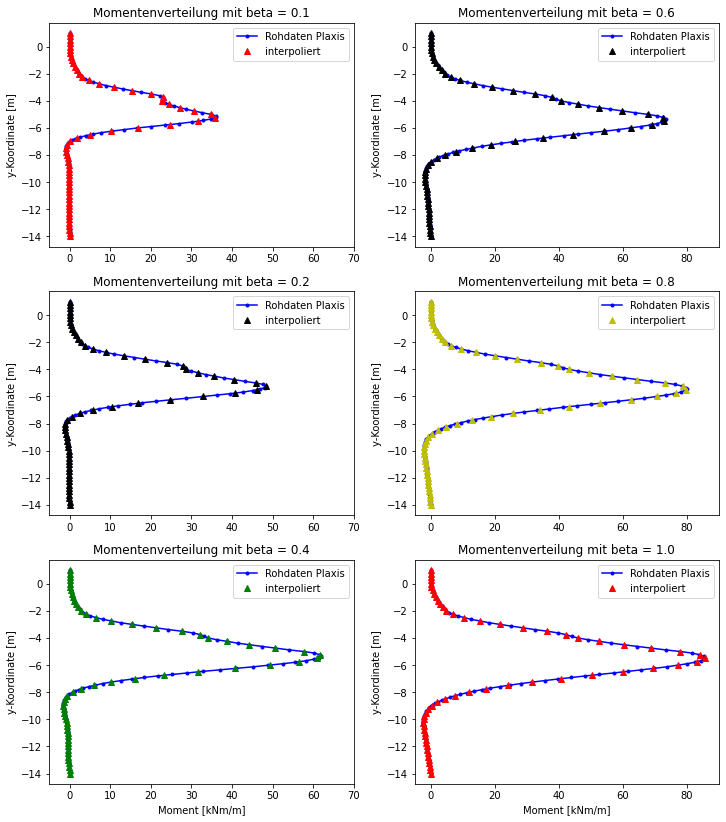

In [ ]:
# compare the interpolated moment with the rawdata from Plaxis 2D

plt.figure(figsize=(12,14))

plt.subplot(3,2,1)
plt.title('Momentenverteilung mit beta = 0.1')
plt.plot(df_plaxis_M['Phase_4_[kNm/m]_01'], df_plaxis_M['Y_coordinate_[m]_01'], 'b.-', label = 'Rohdaten Plaxis')
plt.plot(df_BC_single_A[('beta_01', 'moment_M')], df_fit_inclino['Y_coord'], 'r^', label = 'interpoliert')
plt.xlim(-5, 70)
plt.ylabel('y-Koordinate [m]')
plt.legend()


plt.subplot(3,2,2)
plt.title('Momentenverteilung mit beta = 0.6')
plt.plot(df_plaxis_M['Phase_4_[kNm/m]_06'], df_plaxis_M['Y_coordinate_[m]_06'], 'b.-', label = 'Rohdaten Plaxis')
plt.plot(df_BC_single_A[('beta_06', 'moment_M')], df_fit_inclino['Y_coord'], 'k^', label = 'interpoliert')
plt.xlim(-5, 90)
plt.ylabel('y-Koordinate [m]')
plt.legend()


plt.subplot(3,2,3)
plt.title('Momentenverteilung mit beta = 0.2')
plt.plot(df_plaxis_M['Phase_4_[kNm/m]_02'], df_plaxis_M['Y_coordinate_[m]_02'], 'b.-', label = 'Rohdaten Plaxis')
plt.plot(df_BC_single_A[('beta_02', 'moment_M')], df_fit_inclino['Y_coord'], 'k^', label = 'interpoliert')
plt.xlim(-5, 70)
plt.ylabel('y-Koordinate [m]')
plt.legend()


plt.subplot(3,2,4)
plt.title('Momentenverteilung mit beta = 0.8')
plt.plot(df_plaxis_M['Phase_4_[kNm/m]_08'], df_plaxis_M['Y_coordinate_[m]_08'], 'b.-', label = 'Rohdaten Plaxis')
plt.plot(df_BC_single_A[('beta_08', 'moment_M')], df_fit_inclino['Y_coord'], 'y^', label = 'interpoliert')
plt.xlim(-5, 90)
plt.ylabel('y-Koordinate [m]')
plt.legend()


plt.subplot(3,2,5)
plt.title('Momentenverteilung mit beta = 0.4')
plt.plot(df_plaxis_M['Phase_4_[kNm/m]_04'], df_plaxis_M['Y_coordinate_[m]_04'], 'b.-', label = 'Rohdaten Plaxis')
plt.plot(df_BC_single_A[('beta_04', 'moment_M')], df_fit_inclino['Y_coord'], 'g^', label = 'interpoliert')
plt.xlim(-5, 70)
plt.xlabel('Moment [kNm/m]')
plt.ylabel('y-Koordinate [m]')
plt.legend()


plt.subplot(3,2,6)
plt.title('Momentenverteilung mit beta = 1.0')
plt.plot(df_plaxis_M['Phase_4_[kNm/m]_10'], df_plaxis_M['Y_coordinate_[m]_10'], 'b.-', label = 'Rohdaten Plaxis')
plt.plot(df_BC_single_A[('beta_10', 'moment_M')], df_fit_inclino['Y_coord'], 'r^', label = 'interpoliert')
plt.xlim(-5, 90)
plt.xlabel('Moment [kNm/m]')
plt.ylabel('y-Koordinate [m]')
plt.legend()


plt.show()

# 3.3. Single piles

The variables are named according to the following notation: 
*   "BC" stands for back calculation
*   "A" stands for inclinometers direction A
*   "total" stands for total inclinometers displacement

## Inclinometers direction A

In [ ]:
# Let's back calculate the reduction factor beta. 

# stiffness for a continuous sheet pile wall of PU22-profiles, according to Arcelor Mittal, in [kNm2/m]
EI_continuous = 103866

# the two dataframes work with different indeces: 
# df_BC_single_A: 1.00, 0.75, 0.50, ...
# df_fit_inclino: 0, 1, 2, ...
i = 0

for index, row in df_BC_single_A.iterrows():
  
  # EI = M / w2
  df_BC_single_A.at[index, ('beta_01', 'stiffness_EI')] = df_BC_single_A.at[index, ('beta_01', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_A']
  df_BC_single_A.at[index, ('beta_02', 'stiffness_EI')] = df_BC_single_A.at[index, ('beta_02', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_A']
  df_BC_single_A.at[index, ('beta_04', 'stiffness_EI')] = df_BC_single_A.at[index, ('beta_04', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_A']
  df_BC_single_A.at[index, ('beta_06', 'stiffness_EI')] = df_BC_single_A.at[index, ('beta_06', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_A']
  df_BC_single_A.at[index, ('beta_08', 'stiffness_EI')] = df_BC_single_A.at[index, ('beta_08', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_A']
  df_BC_single_A.at[index, ('beta_10', 'stiffness_EI')] = df_BC_single_A.at[index, ('beta_10', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_A']

  # beta = EI / EI_continuous
  df_BC_single_A.at[index, ('beta_01', 'beta')] = df_BC_single_A.at[index, ('beta_01', 'stiffness_EI')] / EI_continuous
  df_BC_single_A.at[index, ('beta_02', 'beta')] = df_BC_single_A.at[index, ('beta_02', 'stiffness_EI')] / EI_continuous
  df_BC_single_A.at[index, ('beta_04', 'beta')] = df_BC_single_A.at[index, ('beta_04', 'stiffness_EI')] / EI_continuous
  df_BC_single_A.at[index, ('beta_06', 'beta')] = df_BC_single_A.at[index, ('beta_06', 'stiffness_EI')] / EI_continuous
  df_BC_single_A.at[index, ('beta_08', 'beta')] = df_BC_single_A.at[index, ('beta_08', 'stiffness_EI')] / EI_continuous
  df_BC_single_A.at[index, ('beta_10', 'beta')] = df_BC_single_A.at[index, ('beta_10', 'stiffness_EI')] / EI_continuous
  
  i += 1

# df_BC_single_A

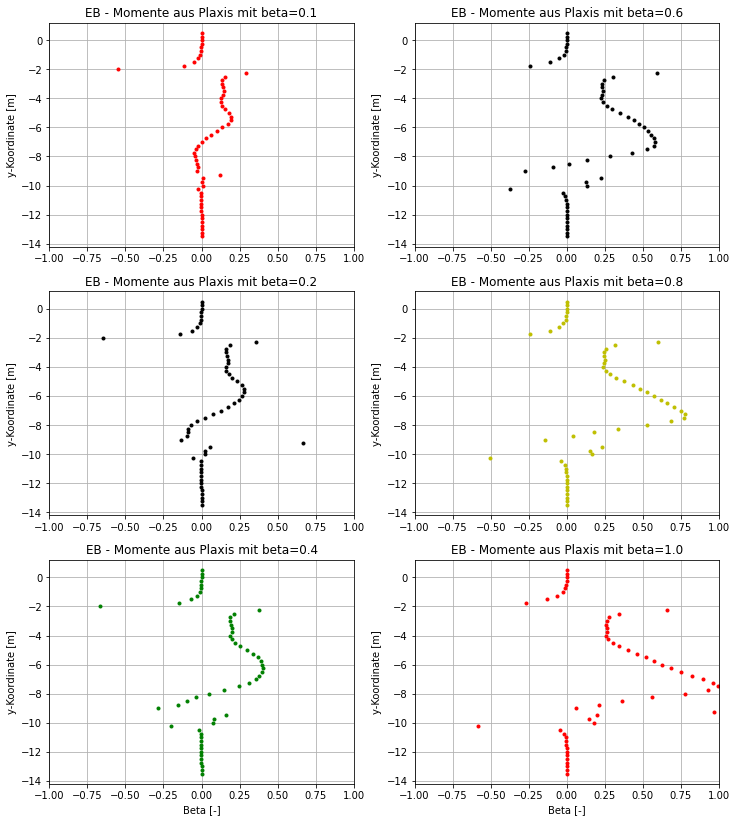

In [ ]:
# EB stands for "Einzelbohlen"
# Inclinometer deformations in direction A

plt.figure(figsize=(12,14))


plt.subplot(3,2,1)
plt.title('EB - Momente aus Plaxis mit beta=0.1')
plt.plot(df_BC_single_A[('beta_01', 'beta')], df_fit_inclino['Y_coord'], 'r.', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,2)
plt.title('EB - Momente aus Plaxis mit beta=0.6')
plt.plot(df_BC_single_A[('beta_06', 'beta')], df_fit_inclino['Y_coord'], 'k.', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,3)
plt.title('EB - Momente aus Plaxis mit beta=0.2')
plt.plot(df_BC_single_A[('beta_02', 'beta')], df_fit_inclino['Y_coord'], 'k.', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,4)
plt.title('EB - Momente aus Plaxis mit beta=0.8')
plt.plot(df_BC_single_A[('beta_08', 'beta')], df_fit_inclino['Y_coord'], 'y.', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,5)
plt.title('EB - Momente aus Plaxis mit beta=0.4')
plt.plot(df_BC_single_A[('beta_04', 'beta')], df_fit_inclino['Y_coord'], 'g.', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Beta [-]')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,6)
plt.title('EB - Momente aus Plaxis mit beta=1.0')
plt.plot(df_BC_single_A[('beta_10', 'beta')], df_fit_inclino['Y_coord'], 'r.', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Beta [-]')
plt.ylabel('y-Koordinate [m]')


plt.show()

In [ ]:
# Let's save the back calculated beta in a multi-index dataframe called df_beta_summary

#sheet_piles = ['single piles', 'grouted piles']
#displacement = ['direction A', 'total']
#reduction_factor = ['beta_01', 'beta_02', 'beta_04', 'beta_06', 'beta_08', 'beta_10']

my_index = pd.MultiIndex.from_product([sheet_piles, displacement], names=['sheet piles', 'displacement'])
df_beta_summary = pd.DataFrame(np.zeros([4, 6]), index=my_index, columns = reduction_factor)

# df_beta_summary

In [ ]:
# Calculate the average beta at a given depth.
# Between 2.5 m and 4 m the values for beta are stable.

df_beta_summary.loc[('single piles', 'direction A'), 'beta_01'] = round(df_BC_single_A.loc[-2.5:-4 , ('beta_01', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'direction A'), 'beta_02'] = round(df_BC_single_A.loc[-2.5:-4 , ('beta_02', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'direction A'), 'beta_04'] = round(df_BC_single_A.loc[-2.5:-4 , ('beta_04', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'direction A'), 'beta_06'] = round(df_BC_single_A.loc[-2.5:-4 , ('beta_06', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'direction A'), 'beta_08'] = round(df_BC_single_A.loc[-2.5:-4 , ('beta_08', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'direction A'), 'beta_10'] = round(df_BC_single_A.loc[-2.5:-4 , ('beta_10', 'beta')].mean(), 3)

#df_beta_summary

## Total inclinometers displacement

In [ ]:
# Let's back calculate the reduction factor beta. 

# stiffness for a continuous sheet pile wall of PU22-profiles, according to Arcelor Mittal, in [kNm2/m]
EI_continuous = 103866

# the two dataframes work with different indeces: 
# df_BC_single_total: 1.00, 0.75, 0.50, ...
# df_fit_inclino: 0, 1, 2, ...
i = 0

for index, row in df_BC_single_total.iterrows():
  
  # EI = M / w2
  df_BC_single_total.at[index, ('beta_01', 'stiffness_EI')] = df_BC_single_total.at[index, ('beta_01', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_total']
  df_BC_single_total.at[index, ('beta_02', 'stiffness_EI')] = df_BC_single_total.at[index, ('beta_02', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_total']
  df_BC_single_total.at[index, ('beta_04', 'stiffness_EI')] = df_BC_single_total.at[index, ('beta_04', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_total']
  df_BC_single_total.at[index, ('beta_06', 'stiffness_EI')] = df_BC_single_total.at[index, ('beta_06', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_total']
  df_BC_single_total.at[index, ('beta_08', 'stiffness_EI')] = df_BC_single_total.at[index, ('beta_08', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_total']
  df_BC_single_total.at[index, ('beta_10', 'stiffness_EI')] = df_BC_single_total.at[index, ('beta_10', 'moment_M')] / df_fit_inclino.at[i, 'w2_single_total']

  # beta = EI / EI_continuous
  df_BC_single_total.at[index, ('beta_01', 'beta')] = df_BC_single_total.at[index, ('beta_01', 'stiffness_EI')] / EI_continuous
  df_BC_single_total.at[index, ('beta_02', 'beta')] = df_BC_single_total.at[index, ('beta_02', 'stiffness_EI')] / EI_continuous
  df_BC_single_total.at[index, ('beta_04', 'beta')] = df_BC_single_total.at[index, ('beta_04', 'stiffness_EI')] / EI_continuous
  df_BC_single_total.at[index, ('beta_06', 'beta')] = df_BC_single_total.at[index, ('beta_06', 'stiffness_EI')] / EI_continuous
  df_BC_single_total.at[index, ('beta_08', 'beta')] = df_BC_single_total.at[index, ('beta_08', 'stiffness_EI')] / EI_continuous
  df_BC_single_total.at[index, ('beta_10', 'beta')] = df_BC_single_total.at[index, ('beta_10', 'stiffness_EI')] / EI_continuous
  
  i += 1

# df_BC_single_total

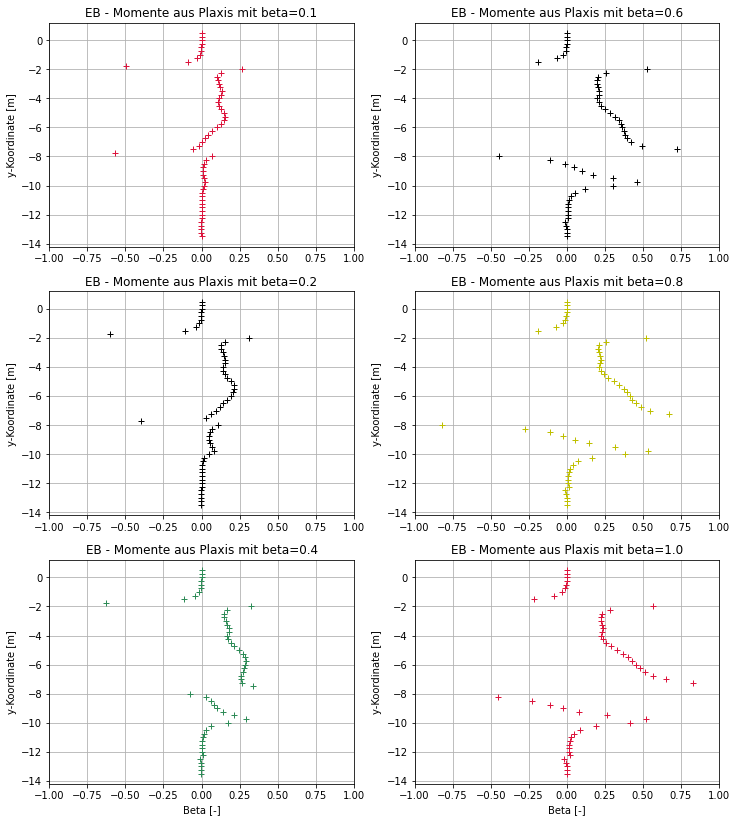

In [ ]:
# EB stands for "Einzelbohlen"
# Inclinometer deformations in direction A

plt.figure(figsize=(12,14))


plt.subplot(3,2,1)
plt.title('EB - Momente aus Plaxis mit beta=0.1')
plt.plot(df_BC_single_total[('beta_01', 'beta')], df_fit_inclino['Y_coord'], color='crimson', marker='+', linestyle='', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,2)
plt.title('EB - Momente aus Plaxis mit beta=0.6')
plt.plot(df_BC_single_total[('beta_06', 'beta')], df_fit_inclino['Y_coord'], 'k+', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,3)
plt.title('EB - Momente aus Plaxis mit beta=0.2')
plt.plot(df_BC_single_total[('beta_02', 'beta')], df_fit_inclino['Y_coord'], 'k+', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,4)
plt.title('EB - Momente aus Plaxis mit beta=0.8')
plt.plot(df_BC_single_total[('beta_08', 'beta')], df_fit_inclino['Y_coord'], 'y+', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,5)
plt.title('EB - Momente aus Plaxis mit beta=0.4')
plt.plot(df_BC_single_total[('beta_04', 'beta')], df_fit_inclino['Y_coord'], color='seagreen', marker='+', linestyle='', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Beta [-]')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,6)
plt.title('EB - Momente aus Plaxis mit beta=1.0')
plt.plot(df_BC_single_total[('beta_10', 'beta')], df_fit_inclino['Y_coord'], color='crimson', marker='+', linestyle='', label = 'beta')
plt.xlim(-1, 1)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Beta [-]')
plt.ylabel('y-Koordinate [m]')


plt.show()

In [ ]:
# Calculate the average beta at a given depth.
# Between 2.5 m and 4 m the values for beta are stable.

df_beta_summary.loc[('single piles', 'total'), 'beta_01'] = round(df_BC_single_total.loc[-2.5:-4 , ('beta_01', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'total'), 'beta_02'] = round(df_BC_single_total.loc[-2.5:-4 , ('beta_02', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'total'), 'beta_04'] = round(df_BC_single_total.loc[-2.5:-4 , ('beta_04', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'total'), 'beta_06'] = round(df_BC_single_total.loc[-2.5:-4 , ('beta_06', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'total'), 'beta_08'] = round(df_BC_single_total.loc[-2.5:-4 , ('beta_08', 'beta')].mean(), 3)
df_beta_summary.loc[('single piles', 'total'), 'beta_10'] = round(df_BC_single_total.loc[-2.5:-4 , ('beta_10', 'beta')].mean(), 3)

#df_beta_summary

# 3.4. Grouted piles

The variables are named according to the following notation: 
*   "BC" stands for back calculation
*   "A" stands for inclinometers direction A
*   "total" stands for total inclinometers displacement

In [ ]:
# Let's construct a multi-index dataframe where we are going to save all of our calculation results. 
# grouted piles

reduction_factor = ['beta_01', 'beta_02', 'beta_04', 'beta_06', 'beta_08', 'beta_10']   # these are the reduction factors used in the Plaxis simulations
Y_coord = Y_coord
back_calculation = ['moment_M', 'stiffness_EI', 'beta'] # we aim at back calculationg beta

my_index = pd.MultiIndex.from_product([reduction_factor, back_calculation], names=['reduction factor', 'back calculation'])

# A stands for inclinometers direction A
df_BC_grouted_A = pd.DataFrame(np.zeros([18, 61]), index=my_index, columns = Y_coord)  # BC means back calculation
df_BC_grouted_A = df_BC_grouted_A.T
#df_BC_grouted_A

In [ ]:
# the moment is the same as for the single piles

df_BC_grouted_A.loc[:, ('beta_01', 'moment_M')] = df_BC_single_A.loc[:, ('beta_01', 'moment_M')]
df_BC_grouted_A.loc[:, ('beta_02', 'moment_M')] = df_BC_single_A.loc[:, ('beta_02', 'moment_M')]
df_BC_grouted_A.loc[:, ('beta_04', 'moment_M')] = df_BC_single_A.loc[:, ('beta_04', 'moment_M')]
df_BC_grouted_A.loc[:, ('beta_06', 'moment_M')] = df_BC_single_A.loc[:, ('beta_06', 'moment_M')]
df_BC_grouted_A.loc[:, ('beta_08', 'moment_M')] = df_BC_single_A.loc[:, ('beta_08', 'moment_M')]
df_BC_grouted_A.loc[:, ('beta_10', 'moment_M')] = df_BC_single_A.loc[:, ('beta_10', 'moment_M')]
#df_BC_grouted_A


# total stands for inclinometers total deformation
df_BC_grouted_total = df_BC_grouted_A
#df_BC_grouted_total

## Inclinometers direction A

In [ ]:
# Let's back calculate the reduction factor beta. 

# stiffness for a continuous sheet pile wall of PU22-profiles, according to Arcelor Mittal, in [kNm2/m]
EI_continuous = 103866

# the two dataframes work with different indeces: 
# df_BC_grouted_A: 1.00, 0.75, 0.50, ...
# df_fit_inclino: 0, 1, 2, ...
i = 0

for index, row in df_BC_grouted_A.iterrows():
  # EI = M / w2
  df_BC_grouted_A.at[index, ('beta_01', 'stiffness_EI')] = df_BC_grouted_A.at[index, ('beta_01', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_A']
  df_BC_grouted_A.at[index, ('beta_02', 'stiffness_EI')] = df_BC_grouted_A.at[index, ('beta_02', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_A']
  df_BC_grouted_A.at[index, ('beta_04', 'stiffness_EI')] = df_BC_grouted_A.at[index, ('beta_04', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_A']
  df_BC_grouted_A.at[index, ('beta_06', 'stiffness_EI')] = df_BC_grouted_A.at[index, ('beta_06', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_A']
  df_BC_grouted_A.at[index, ('beta_08', 'stiffness_EI')] = df_BC_grouted_A.at[index, ('beta_08', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_A']
  df_BC_grouted_A.at[index, ('beta_10', 'stiffness_EI')] = df_BC_grouted_A.at[index, ('beta_10', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_A']
  
  # beta = EI / EI_continuous
  df_BC_grouted_A.at[index, ('beta_01', 'beta')] = df_BC_grouted_A.at[index, ('beta_01', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_A.at[index, ('beta_02', 'beta')] = df_BC_grouted_A.at[index, ('beta_02', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_A.at[index, ('beta_04', 'beta')] = df_BC_grouted_A.at[index, ('beta_04', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_A.at[index, ('beta_06', 'beta')] = df_BC_grouted_A.at[index, ('beta_06', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_A.at[index, ('beta_08', 'beta')] = df_BC_grouted_A.at[index, ('beta_08', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_A.at[index, ('beta_10', 'beta')] = df_BC_grouted_A.at[index, ('beta_10', 'stiffness_EI')] / EI_continuous
  i += 1

#df_BC_grouted_A

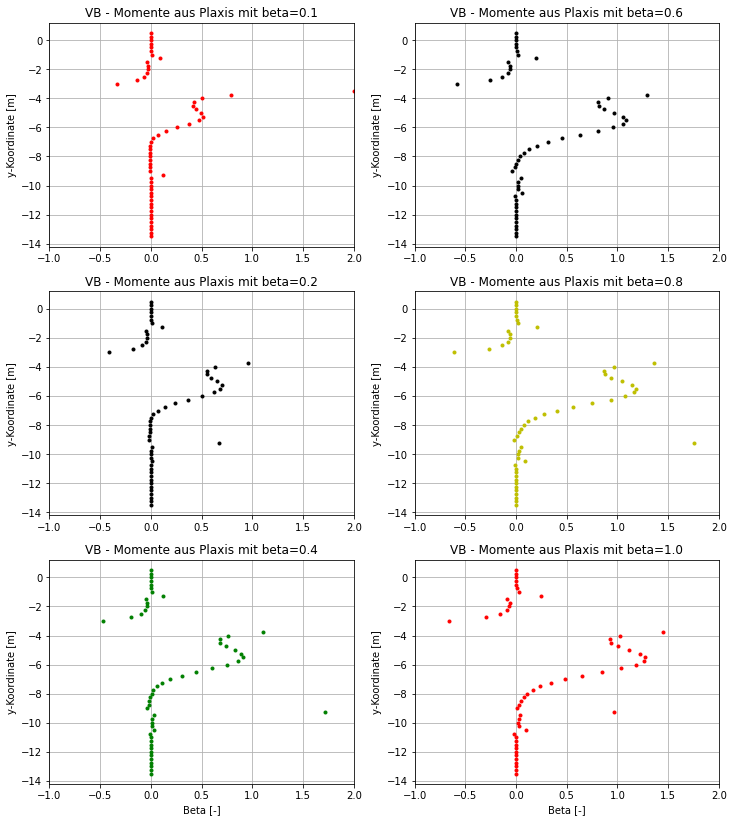

In [ ]:
# VB stands for "vorverklebte Bohlen"
# Inclinometer deformations in direction A

plt.figure(figsize=(12,14))


plt.subplot(3,2,1)
plt.title('VB - Momente aus Plaxis mit beta=0.1')
plt.plot(df_BC_grouted_A[('beta_01', 'beta')], df_fit_inclino['Y_coord'], 'r.', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,2)
plt.title('VB - Momente aus Plaxis mit beta=0.6')
plt.plot(df_BC_grouted_A[('beta_06', 'beta')], df_fit_inclino['Y_coord'], 'k.', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,3)
plt.title('VB - Momente aus Plaxis mit beta=0.2')
plt.plot(df_BC_grouted_A[('beta_02', 'beta')], df_fit_inclino['Y_coord'], 'k.', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,4)
plt.title('VB - Momente aus Plaxis mit beta=0.8')
plt.plot(df_BC_grouted_A[('beta_08', 'beta')], df_fit_inclino['Y_coord'], 'y.', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,5)
plt.title('VB - Momente aus Plaxis mit beta=0.4')
plt.plot(df_BC_grouted_A[('beta_04', 'beta')], df_fit_inclino['Y_coord'], 'g.', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Beta [-]')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,6)
plt.title('VB - Momente aus Plaxis mit beta=1.0')
plt.plot(df_BC_grouted_A[('beta_10', 'beta')], df_fit_inclino['Y_coord'], 'r.', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Beta [-]')
plt.ylabel('y-Koordinate [m]')


plt.show()

In [ ]:
# Calculate the average beta at a given depth.
# Between 4 m and 5 m the values for beta are somewhat stable. 
# We exclude the values at a depth of 5-6 m because the peak occasionally exceeds 1 (which is impossible). 

df_beta_summary.loc[('grouted piles', 'direction A'), 'beta_01'] = round(df_BC_grouted_A.loc[-4:-5 , ('beta_01', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'direction A'), 'beta_02'] = round(df_BC_grouted_A.loc[-4:-5 , ('beta_02', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'direction A'), 'beta_04'] = round(df_BC_grouted_A.loc[-4:-5 , ('beta_04', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'direction A'), 'beta_06'] = round(df_BC_grouted_A.loc[-4:-5 , ('beta_06', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'direction A'), 'beta_08'] = round(df_BC_grouted_A.loc[-4:-5 , ('beta_08', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'direction A'), 'beta_10'] = round(df_BC_grouted_A.loc[-4:-5 , ('beta_10', 'beta')].mean(), 3)

#df_beta_summary

## Total inclinometers displacement

In [ ]:
# Let's back calculate the reduction factor beta. 

# stiffness for a continuous sheet pile wall of PU22-profiles, according to Arcelor Mittal, in [kNm2/m]
EI_continuous = 103866

# the two dataframes work with different indeces: 
# df_BC_grouted_total: 1.00, 0.75, 0.50, ...
# df_fit_inclino: 0, 1, 2, ...
i = 0

for index, row in df_BC_grouted_total.iterrows():
  # EI = M / w2
  df_BC_grouted_total.at[index, ('beta_01', 'stiffness_EI')] = df_BC_grouted_total.at[index, ('beta_01', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_total']
  df_BC_grouted_total.at[index, ('beta_02', 'stiffness_EI')] = df_BC_grouted_total.at[index, ('beta_02', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_total']
  df_BC_grouted_total.at[index, ('beta_04', 'stiffness_EI')] = df_BC_grouted_total.at[index, ('beta_04', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_total']
  df_BC_grouted_total.at[index, ('beta_06', 'stiffness_EI')] = df_BC_grouted_total.at[index, ('beta_06', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_total']
  df_BC_grouted_total.at[index, ('beta_08', 'stiffness_EI')] = df_BC_grouted_total.at[index, ('beta_08', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_total']
  df_BC_grouted_total.at[index, ('beta_10', 'stiffness_EI')] = df_BC_grouted_total.at[index, ('beta_10', 'moment_M')] / df_fit_inclino.at[i, 'w2_grouted_total']
  
  # beta = EI / EI_continuous
  df_BC_grouted_total.at[index, ('beta_01', 'beta')] = df_BC_grouted_total.at[index, ('beta_01', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_total.at[index, ('beta_02', 'beta')] = df_BC_grouted_total.at[index, ('beta_02', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_total.at[index, ('beta_04', 'beta')] = df_BC_grouted_total.at[index, ('beta_04', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_total.at[index, ('beta_06', 'beta')] = df_BC_grouted_total.at[index, ('beta_06', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_total.at[index, ('beta_08', 'beta')] = df_BC_grouted_total.at[index, ('beta_08', 'stiffness_EI')] / EI_continuous
  df_BC_grouted_total.at[index, ('beta_10', 'beta')] = df_BC_grouted_total.at[index, ('beta_10', 'stiffness_EI')] / EI_continuous
  i += 1

#df_BC_grouted_total

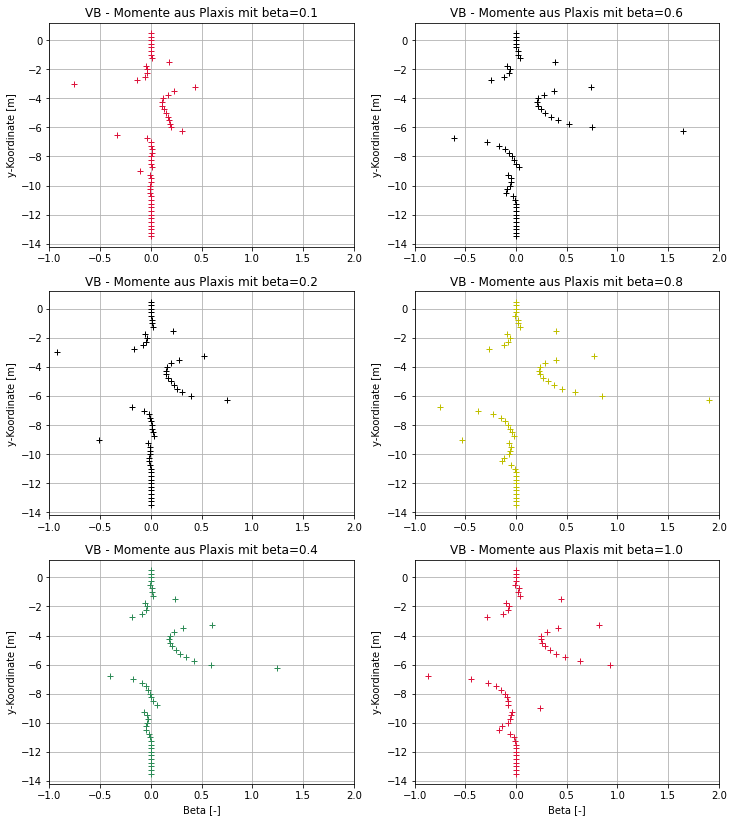

In [ ]:
# VB stands for "vorverklebte Bohlen"
# Inclinometers total displacements

plt.figure(figsize=(12,14))


plt.subplot(3,2,1)
plt.title('VB - Momente aus Plaxis mit beta=0.1')
plt.plot(df_BC_grouted_total[('beta_01', 'beta')], df_fit_inclino['Y_coord'], color='crimson', marker='+', linestyle='', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,2)
plt.title('VB - Momente aus Plaxis mit beta=0.6')
plt.plot(df_BC_grouted_total[('beta_06', 'beta')], df_fit_inclino['Y_coord'], 'k+', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,3)
plt.title('VB - Momente aus Plaxis mit beta=0.2')
plt.plot(df_BC_grouted_total[('beta_02', 'beta')], df_fit_inclino['Y_coord'], 'k+', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,4)
plt.title('VB - Momente aus Plaxis mit beta=0.8')
plt.plot(df_BC_grouted_total[('beta_08', 'beta')], df_fit_inclino['Y_coord'], 'y+', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,5)
plt.title('VB - Momente aus Plaxis mit beta=0.4')
plt.plot(df_BC_grouted_total[('beta_04', 'beta')], df_fit_inclino['Y_coord'], color='seagreen', marker='+', linestyle='', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Beta [-]')
plt.ylabel('y-Koordinate [m]')


plt.subplot(3,2,6)
plt.title('VB - Momente aus Plaxis mit beta=1.0')
plt.plot(df_BC_grouted_total[('beta_10', 'beta')], df_fit_inclino['Y_coord'], color='crimson', marker='+', linestyle='', label = 'beta')
plt.xlim(-1, 2)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Beta [-]')
plt.ylabel('y-Koordinate [m]')


plt.show()

In [ ]:
# Calculate the average beta at a given depth.
# Between 4 m and 5 m the values for beta are somewhat stable. 

df_beta_summary.loc[('grouted piles', 'total'), 'beta_01'] = round(df_BC_grouted_total.loc[-4:-5 , ('beta_01', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'total'), 'beta_02'] = round(df_BC_grouted_total.loc[-4:-5 , ('beta_02', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'total'), 'beta_04'] = round(df_BC_grouted_total.loc[-4:-5 , ('beta_04', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'total'), 'beta_06'] = round(df_BC_grouted_total.loc[-4:-5 , ('beta_06', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'total'), 'beta_08'] = round(df_BC_grouted_total.loc[-4:-5 , ('beta_08', 'beta')].mean(), 3)
df_beta_summary.loc[('grouted piles', 'total'), 'beta_10'] = round(df_BC_grouted_total.loc[-4:-5 , ('beta_10', 'beta')].mean(), 3)

#df_beta_summary

# 3.5. Summary

In [ ]:
df_beta_summary

beta_01  beta_02  beta_04  beta_06  beta_08  \
sheet piles   displacement                                                
single piles  direction A     0.139    0.170    0.196    0.245    0.258   
              total           0.117    0.143    0.164    0.205    0.215   
grouted piles direction A     0.460    0.598    0.739    0.874    0.939   
              total           0.125    0.163    0.201    0.238    0.255   

                            beta_10  
sheet piles   displacement           
single piles  direction A     0.276  
              total           0.230  
grouted piles direction A     1.001  
              total           0.272

Following conclusions are drawn from the back calculation with a **linear interpolation** of the moment distribution obtained with Plaxis 2D: 

*   As expected, the reduction factors $\beta_D$ from inclinometers total displacements are lower that those obtained with the displacement in direction A. 

*   For the singles piles the difference between the reduction factors are low. $$ Single: \qquad \frac{\beta_D (\, direction A )\,}{\beta_D (\, total )\, } = 1.2 $$

*   For the grouted piles, on the other hand, the reduction factors obtained with the inclinometers total displacements and the displacement in direction A show significant differences! It's not excluded that this difference is related to the shape of the deformed piles in situ, not corresponding to the shape obtained with the Plaxis simulations. $$ Grouted: \qquad \frac{\beta_D (\, direction A )\,}{\beta_D (\, total )\, } = 3.7 $$

*   For the single piles, we estimate the reduction factor as follows: $$ \beta_D \approx 0.2 - 0.3 $$

*   For the grouted piles, we estimate the reduction factor as follows: $$ \beta_D \approx 0.9 - 1.0 $$

*   In general, the linear interpolation delivers lower values compared to the polynomial of 7th degree (see `'08_plaxis_polynomial.ipynb'`).